<a href="https://colab.research.google.com/github/ak-org/notebooks/blob/master/triplet_loss_in_defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 65kB/s 
     |████████████████████████████████| 501kB 54.6MB/s 
     |████████████████████████████████| 4.3MB 49.8MB/s 


In [295]:
import tensorflow as tf 
from tensorflow import keras
import math
import sklearn
import random

print(tf.__version__)
print(keras.__version__)

2.0.0-rc1
2.2.4-tf


In [0]:
## dataset
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, concatenate,  Dropout
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes


## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

In [0]:
def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

In [0]:
def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

In [0]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

In [0]:
cifar10_labels = ['Airplanes', 'Automobiles', 'Birds', 'Cats', 'Deers', 'Dogs', 'Frogs', 'Horse', 'Ship', 'Truck']

# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
input_image_shape = (32, 32, 3)

In [0]:
def create_base_network(image_input_shape = (32, 32, 3), embedding_size = 64):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_image = Input(shape=image_input_shape)
    weight_decay = 1e-4
    actv = 'elu'
    x = Conv2D(32, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(input_image)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(x)   
    x = BatchNormalization()(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(x)   
    x = BatchNormalization()(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, kernel_regularizer=regularizers.l2(weight_decay), activation=actv)(x)   
    x = BatchNormalization()(x) 
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(embedding_size)(x)
    base_network = Model(inputs=input_image, outputs=x)
    return base_network

In [326]:
create_base_network()

In [0]:
def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate


Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_92 (Model)                (None, 64)           330080      input_image[0][0]                
__________________________________________________________________________________________________
concatenate_35 (Concatenate)    (None, 65)           0           input_label[0][0]                
                                                                 model_92[1][0]            

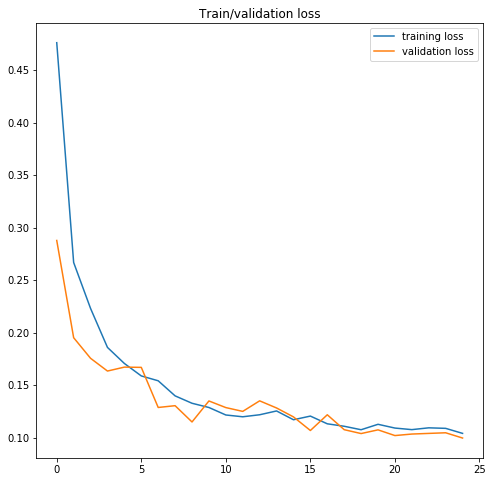

In [332]:
 if train_flag == True:
        batch_size = 128
        epochs = 25
        train_flag = True  # either     True or False
        embedding_size = 64
        no_of_components = 2  # for visualization -> PCA.fit_transform()
        step = 10
        lr = 0.0001
        base_network = create_base_network()

        input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
        input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
        embeddings = base_network([input_images])               # output of network -> embeddings
        labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

        # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
        model = Model(inputs=[input_images, input_labels],
                      outputs=labels_plus_embeddings)

        model.summary()

        # train session
        opt = Adam(lr=lr, epsilon = 1e-7)  # choose optimiser. RMS is good too!
        #opt  = RMSprop(lr=lr,decay=1e-6)

        model.compile(loss=triplet_loss_adapted_from_tf,
                      optimizer=opt)

        filepath = "semiH_trip_CIFAR_v13_ep{epoch:02d}_BS%d.hdf5" % batch_size
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=25)
        lrate = LearningRateScheduler(step_decay)
        callbacks_list = [checkpoint, lrate]

        # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
        dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
        dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

        x_train = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[2],  x_train.shape[3]))
        x_val = np.reshape(x_val, (len(x_val), x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        H = model.fit(
            x=[x_train,y_train],
            y=dummy_gt_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([x_val, y_val], dummy_gt_val),
            callbacks=callbacks_list)
        plt.figure(figsize=(8,8))
        plt.plot(H.history['loss'], label='training loss')
        plt.plot(H.history['val_loss'], label='validation loss')
        plt.legend()
        plt.title('Train/validation loss')
        plt.show()
else:
        model = load_model('semiH_trip_CIFAR_v13_ep25_BS256.hdf5',
                            custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

In [0]:
# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
                                          embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 32, 32, 3)))
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

In [334]:

# Visualizing the effect of embeddings -> using PCA!

x_embeddings = testing_embeddings.predict(np.reshape(x_test, (len(x_test), 32, 32, 3)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_test))
print(x_embeddings.shape, test_class_labels.shape)



(10000, 64) (10,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Test
Refernce image is : Ship
[1.6384755 0.        1.5449396 1.606284  1.4066887]
Nearest images are  : Ship
Ship
Ship
Ship
Ship
Ship


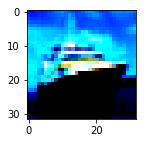

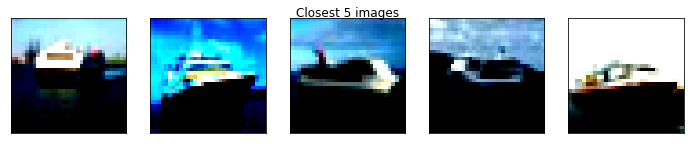

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Farthest image distance is 33.887325286865234
Labels are Ship, Horse


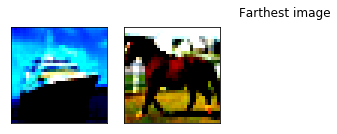

In [343]:

dist = sklearn.metrics.pairwise_distances(x_embeddings)
print("Random Test")
r = random.randint(0, 10001) 
plt.figure(figsize = (2,2))
plt.imshow(x_test[r])
print("Refernce image is : " + cifar10_labels[y_test[r][0]])
idx = np.argpartition(dist[r], 5)
print(dist[r][idx[:5]])

print("Nearest images are  : " + cifar10_labels[y_test[idx[i]][0]]) 
for i in range(5):
  print(cifar10_labels[y_test[idx[i]][0]]) 


plt.figure(figsize = (10, 2))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[idx[i]])
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
plt.suptitle('Closest 5 images', fontsize = 12)
plt.show()


farthest_idx = np.argmax(dist[r])
print("Farthest image distance is {}".format(dist[r][farthest_idx]))
print("Labels are {}, {}". format(cifar10_labels[y_test[r][0]], cifar10_labels[y_test[farthest_idx][0]]))
far_idx = [r, farthest_idx]
plt.figure(figsize = (8, 2))
for i in range(2):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[far_idx[i]])
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
plt.suptitle('Farthest image', fontsize = 12)
plt.show()

In [344]:
'''
SIZE = 2000
tsne = TSNE(n_components=no_of_components, perplexity = 50)
decomposed_embeddings = tsne.fit_transform(x_embeddings[:SIZE])
decomposed_gray = tsne.fit_transform(x_embeddings_before_train[:SIZE])
'''
print('')

In [345]:
'''

fig = plt.figure(figsize=(20, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_test[:SIZE,0] == label]
    decomposed_gray_class = decomposed_gray[y_test[:SIZE,0] == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0], label=cifar10_labels[label])
    plt.title('before training')
    # Turn off tick labels
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=cifar10_labels[label])
    plt.title('@%d epochs' % epochs)
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
'''
print('')